# Galvų nuotraukoje aptikimas bei pozicijos nustatymas pasitelkus [SSD-Head (Single Shot Multibox Detector)](https://github.com/AVAuco/ssd_head_keras) išmokintą algoritmą.

Šio laboratorinio darbo metu mes naudosime Google Drive kaip saugyklą neuroninio tinklo svoriams, nuotraukoms bei rezultatams išsaugoti.
Pirmiausiai sudarome prisijungimą prie asmeninės Gdrive saugyklos:

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Susikuriame naują folderį asmeninėje Gdrive saugykloje bei:

In [ ]:
path = 'drive/MyDrive/VGTU/Kompiuterine_rega_medicinoje/'
new_folder_name = 'Lab_nr_1'

if not os.path.exists(path + new_folder_name):
    os.mkdir(path + new_folder_name )
    print("folder created")

os.chdir(path + new_folder_name)
os.getcwd()

'/content/drive/MyDrive/VGTU/Kompiuterine_rega_medicinoje/Lab_nr_1'

Parsisiunčiame algoritmo programinį kodą bei visus reikalingus duomenis esančius GitHub repozitorijoje

In [ ]:
!git clone https://github.com/AVAuco/ssd_head_keras.git

fatal: destination path 'ssd_head_keras' already exists and is not an empty directory.


In [ ]:
os.chdir('ssd_head_keras')
os.getcwd()

'/content/drive/MyDrive/VGTU/Kompiuterine_rega_medicinoje/Lab_nr_1/ssd_head_keras'

In [ ]:
!ls

bounding_box_utils  demo_inference.ipynb  keras_loss_function  README.md
cookie		    examples		  LICENSE	       requirements.txt
data		    keras_layers	  models


Perinstaliuojame `tensorflow`, `keras`, `h5py` karkasus bei bibliotekas į senesnes versijas (kurių pagalba implementuotas naudojamas neuroninias tinklas):

In [29]:
!pip uninstall -y keras tensorflow-gpu tensorflow
!pip install tensorflow-gpu==1.14 Keras==2.2.4 h5py==2.10.0

Importuojame visas likusias bibliotekas

In [30]:
import urllib.request
from platform import python_version
import subprocess

from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

%matplotlib inline

Atsisiunčiame išmokintus modelio svorių matricas

In [ ]:
py_version = ''.join(python_version().split('.'))
model_version = '3.6'
if int(py_version) < 360:
    model_version = '3.5'
print('Using model version for Python %s.' % model_version)

Using model version for Python 3.6.


In [ ]:
weights_path = './data/ssd512-hollywood-trainval-bs_16-lr_1e-05-scale_pascal-epoch-187-py%s.h5' % model_version

if not os.path.exists(weights_path):

  # Determine which script to use
  script_path = "download_model_py%s.sh" % model_version
  # Download the model file into the "data" directory
  os.chdir('./data/')
  if script_path in os.listdir(os.getcwd()):
      print("Downloading model...")
      subprocess.call('./' + script_path)
      print("Download finished.")
  # Restore the working directory path
  os.chdir('..')

"Įkrauname" atsiųstus modelio svorius į neuroninio tinklo karkasą

In [31]:
# Set the image size.
HEIGHT = 512
WIDTH = 512

# Set the model's inference mode
model_mode = 'inference'

# Set the desired confidence threshold
conf_thresh = 0.01

# Create an SSDLoss object in order to pass that to the model loader
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# Clear previous models from memory.
K.clear_session() 

# Configure the decode detections layer based on the model mode
if model_mode == 'inference':
    decode_layer = DecodeDetections(img_height=HEIGHT,
                                    img_width=WIDTH,
                                    confidence_thresh=conf_thresh,
                                    iou_threshold=0.45,
                                    top_k=200,
                                    nms_max_output_size=400)
if model_mode == 'inference_fast':
    decode_layer = DecodeDetectionsFast(img_height=HEIGHT,
                                        img_width=WIDTH,
                                        confidence_thresh=conf_thresh,
                                        iou_threshold=0.45,
                                        top_k=200,
                                        nms_max_output_size=400)
    
# Finally load the model
model = load_model(weights_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                                 'L2Normalization': L2Normalization,
                                                 'DecodeDetections': decode_layer,
                                                 'compute_loss': ssd_loss.compute_loss})

Atsisiunčiame bei išsaugome paveiksliukus tolimesniam modelio testavimui

In [ ]:
def download_pics_from_web(urls,save_folder):
  for i, url in enumerate(urls):
    try:
      urllib.request.urlretrieve(url, save_folder + "/fig{}.".format(i) 
                                            + url.split(".")[-1])
    except:
      print("Download failed")
      

In [ ]:
# Sudarome testinių nuotraukų sąrašą
images = [
'https://images.news18.com/ibnlive/uploads/2020/12/1608628695_arsenal-manchester-city.jpg',
'https://static.straitstimes.com.sg/s3fs-public/styles/article_pictrure_780x520_/public/articles/2020/05/25/file79nwa5r0x4619d08rl4g.jpg',
'https://vilniustech.lt/images/3476/173/8/4_1/ESK%202019.jpg',
'https://g4.dcdn.lt/images/pix/430x260/lSIObgu2IOs/europos-futbolo-u21-cempionato-atranka-lietuva-skotija-85242215.jpg',
'https://cdn.mos.cms.futurecdn.net/TK3CFyXDgJDk9xHuJ9LU96.jpg',
'https://cdn-prod.medicalnewstoday.com/content/images/articles/313/313264/african-face.jpg',
'https://staticg.sportskeeda.com/editor/2020/07/5b2c1-15941044808610-800.jpg',
'https://pbs.twimg.com/media/C9XsFPFW0AEgab4.jpg',
'https://upload.wikimedia.org/wikipedia/commons/a/ab/Girl_and_cat.jpg',
'https://cdn.nba.com/manage/2020/12/kawhi-lebron-davis-george.jpg',
'https://www.boredpanda.com/blog/wp-content/uploads/2018/07/fb_image_5b5adfdb72b89.jpg',
'https://www.legendarte.shop/pimages/La-colazione-dei-canottieri-uno-dei-quadri-piu-coinvolgenti-di-R-big-75-250.jpg',
'https://www.boredpanda.com/blog/wp-content/uploads/2020/04/art-recreation-at-home-getty-museum-challenge-fb7-png__700.jpg',
'https://lumiere-a.akamaihd.net/v1/images/image_bf8739ba.jpeg',
'https://i.gadgets360cdn.com/large/simpsons_tv_1598935187074.jpg',
'https://www.cnet.com/a/img/WfkqAocgYhb8A85smYcTH_acFa8=/1200x630/2019/01/11/b251bf04-5bf8-469a-be8d-79489551460b/avatar-2009.jpg',
'https://img.buzzfeed.com/buzzfeed-static/static/2017-04/13/11/tmp/buzzfeed-prod-fastlane-01/tmp-name-2-22503-1492096009-0_dblbig.jpg',
'https://images.ctfassets.net/iyiurthvosft/featured-img-of-post-205798/3cc9a486014e567182f1d1ab40ac6e22/featured-img-of-post-205798.jpg',
'https://cdn.vox-cdn.com/uploads/chorus_asset/file/16309281/Dw6ZIOlX4AMKL9J.jpg',
'https://static.scientificamerican.com/sciam/cache/file/86062BF8-9C23-476B-B0355DCEB376997A_source.jpg'
]

In [ ]:
# Atsisiunčiame bei išsaugome nuotraukas 'examples' folderyje
download_pics_from_web(images,"examples")
!ls examples

fig0.jpg   fig13.jpeg  fig17.jpg  fig2.jpg  fig6.jpg  fish_bike.jpg
fig10.jpg  fig14.jpg   fig18.jpg  fig3.jpg  fig7.jpg  people_drinking.jpg
fig11.jpg  fig15.jpg   fig19.jpg  fig4.jpg  fig8.jpg  rugby_players.jpg
fig12.jpg  fig16.jpg   fig1.jpg   fig5.jpg  fig9.jpg  sample_detections.jpg


Atsidarome paveiksliukus naudojant `keras.preprocessing.image.load_img()` (šios funkcijos viduje naudojama `PIL` biblioteka)

In [ ]:
img_dir = 'examples/'

# Pradiniai paveikslėliai
img_filenames = [file for file in os.listdir(img_dir) if file[:3] == "fig"] 
orig_images = [image.load_img(img_dir+filename) for filename in img_filenames]

# Keičiane paveiksliukų dydžius (HEIGHT, WIDTH)
input_images = [image.img_to_array(image.load_img(  img_dir+filename,
                                                    target_size=(HEIGHT, WIDTH)))
                                                    for filename in img_filenames]
# Transformuojame į numpy.array() masyvą
input_images = np.array(input_images)

Atliekame galvų atpažinimą pasirinktom nuotraukom. Pasirinkome 50% aptikimo slėnkstį.


In [ ]:
def detect_heads(images, conf_thresh):
  y_pred = model.predict(images)
  return [y_pred[k][y_pred[k,:,1] > conf_thresh] for k in range(y_pred.shape[0])]

In [ ]:
results = detect_heads(input_images, 0.5)

Panagrinėjus modelio išėjimo rezultatą, matome, kad yra nusakoma aptikto objekto klasė, spėjimo užtikrintumas, bei objektą apimančio stačiakampio koordinatės

In [ ]:
np.set_printoptions(precision=2, suppress=True, linewidth=90)

for i in range(2):
  print("Predicted boxes:\n")
  print('   class   conf xmin   ymin   xmax   ymax')
  print(results[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   177.67   9.23 310.88 122.43]]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     1.   191.52  51.34 227.66 148.73]
 [  1.     0.98 327.92  32.57 374.33 112.85]]


Atvaizduojame rezultatus

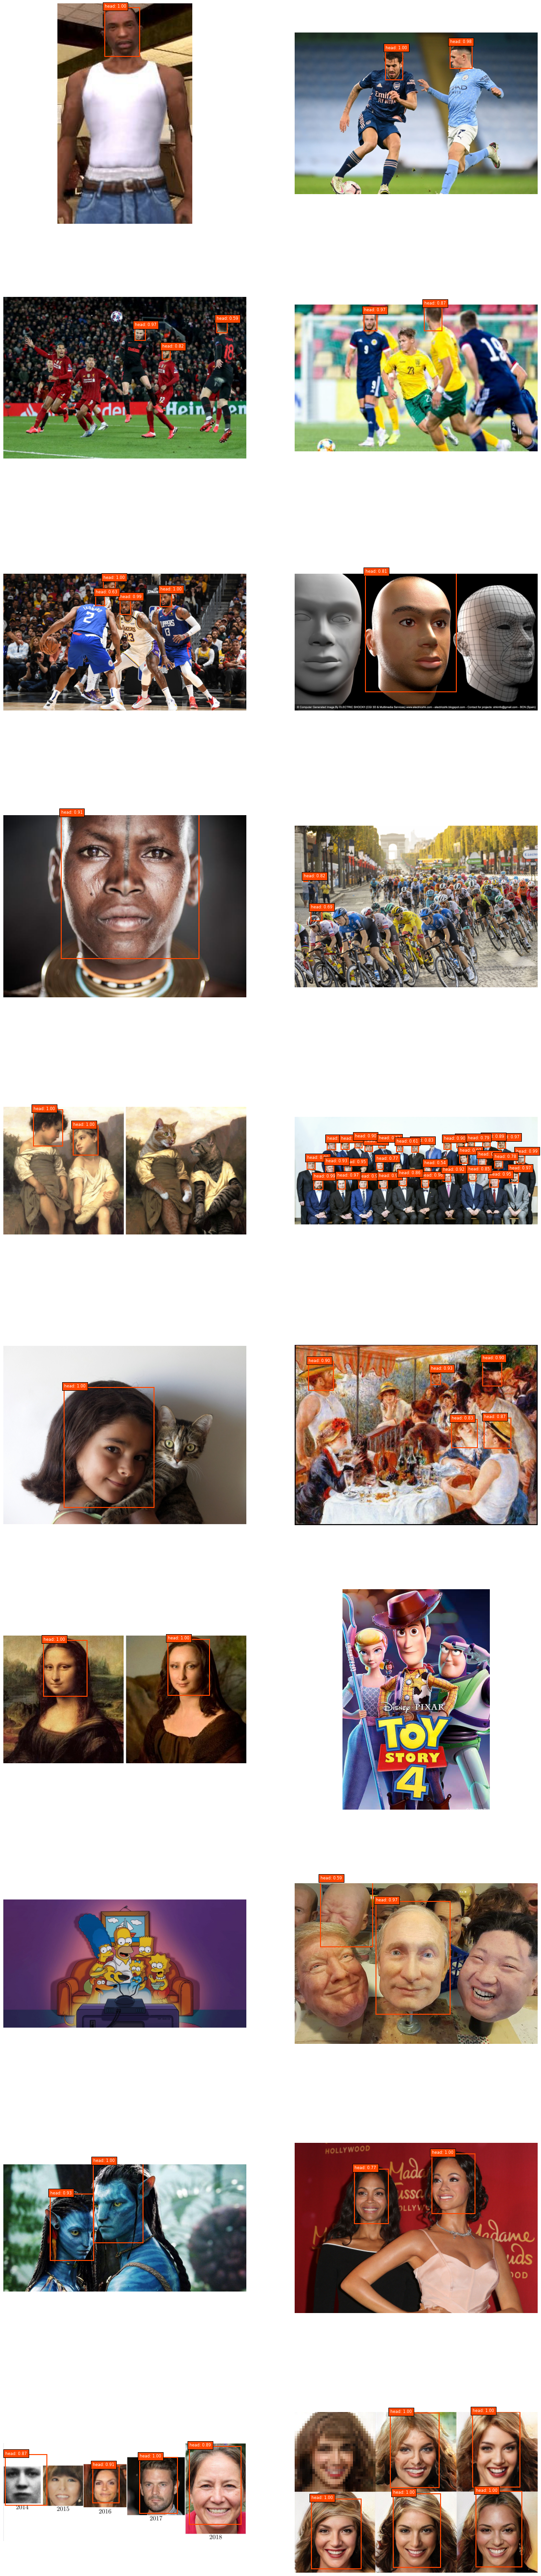

In [ ]:
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background', 'head']

# Configure plot and disable axis
fig, ax = plt.subplots(10,2, figsize=(20,100))

for i in range(len(results)):
  ax[int(i/2)][i%2].set_axis_off()
  fig.add_axes(ax[int(i/2)][i%2])
  ax[int(i/2)][i%2].imshow(orig_images[i])
  current_axis = plt.gca()

  # Display the image and draw the predicted boxes onto it.
  for box in results[i]:
      # Transform the predicted bounding boxes for the 512x512 image to the original image dimensions.
      xmin = box[2] * np.array(orig_images[i]).shape[1] / WIDTH
      ymin = box[3] * np.array(orig_images[i]).shape[0] / HEIGHT
      xmax = box[4] * np.array(orig_images[i]).shape[1] / WIDTH
      ymax = box[5] * np.array(orig_images[i]).shape[0] / HEIGHT
      color = colors[int(box[0])]
      label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
      current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
      current_axis.text(xmin, ymin, label, size='small', color='white', bbox={'facecolor':color, 'alpha':1.0})

Išsaugome paveiksliukus su detektuotas galvas atitinkančiais stačiakampiais bei spėjimo tikslumais

In [ ]:
if not os.path.exists('results'):
  os.mkdir('results')

In [ ]:
for i in range(len(results)):
  extent = ax[int(i/2)][i%2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
  fig.savefig('results/fig{}.png'.format(i), bbox_inches=extent.expanded(1.1))

In [34]:
!ls results

fig0.png   fig12.png  fig15.png  fig18.png  fig2.png  fig5.png	fig8.png
fig10.png  fig13.png  fig16.png  fig19.png  fig3.png  fig6.png	fig9.png
fig11.png  fig14.png  fig17.png  fig1.png   fig4.png  fig7.png


Rezultatų aptarimas:
* Kaip matome, mūsų naudojamas neuroninis tinklas atpažįsta skirtingo dydžio žmogaus galvas (ar tai galva užima mažą plotelį ar net pusę paveikslėlio). 
* Paveikslėliuose su animuotais žmogaus atvaizdais buvo aptiktos žmogaus galvos tik ties tais atvejai kai animuotas personažas atrodo gana realistiškai bei išlaikomos visos veido proporcijos.
* Algoritmo veikimas nėra stabilus ties nuotraukomis su daugeliu žmonių veidais. Vienu atveju algoritmas atpažįsta visus veidus, kitu - tik mažą dalį. Ypatingai galima išskirti nuotrauką su diratininkais devinčiais akinius bei šalmus, kurioje modelis neaptiko (tik vieną/dvi) nei vienos žmogaus galvos. 